# Plot trajectories under different threshold policies

In [1]:
# Load pytorch 

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

execfile("reduction.py")

/nfs/nhome/live/asaxe/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/nfs/nhome/live/asaxe/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/nfs/nhome/live/asaxe/.conda/envs/

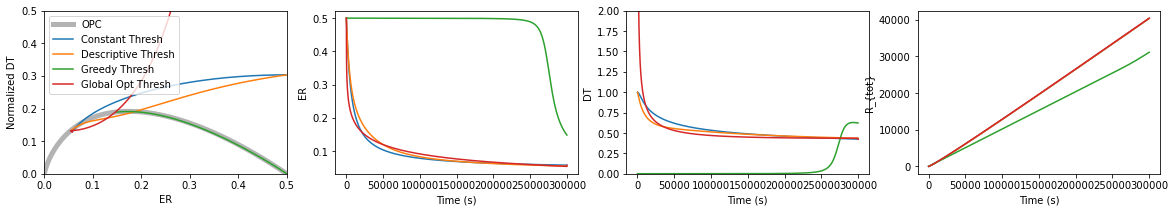

In [2]:
# Plot trajectories under the prior
dt = 60
Nsteps = 5000
Nsamp = 1
time = np.arange(Nsteps)*dt

A = 0.9542
ci = 0.3216
co = 30
w0 = .0001

lr = 4.5942/100.
gamma = 1.1891/100.
DT_target = 0.7427

# Add threshold policies
z0s = []
zpols = []
names = ["OPC"]

# Constant Policy
z0 = 30.

z0s.append(z0)
zpols.append(lambda z,w,zbar,SNR,ER,DT,TT,RR,t,dt,z0=z0: const_zpol(z,w,zbar,SNR,ER,DT,TT,RR,t,dt,z0))
names.append("Constant Thresh")

# Descriptive DT policy
z0 = 30.
gamma = 1.1891/10000

z0s.append(z0)
zpols.append(lambda z,w,zbar,SNR,ER,DT,TT,RR,t,dt,gamma=gamma: descriptive_zpol(z,w,zbar,SNR,ER,DT,TT,RR,t,dt,gamma))
names.append("Descriptive Thresh")

# Greedy DT policy
z0 = 1.
gamma = 1.1891/100

z0s.append(z0)
zpols.append(lambda z,w,zbar,SNR,ER,DT,TT,RR,t,dt,gamma=gamma: descriptive_zpol(z,w,zbar,SNR,ER,DT,TT,RR,t,dt,gamma))
names.append("Greedy Thresh")

# Globally optimal oracle policy

dat = np.load('globally_optimal_thres.npz')
zopt = dat['z']
z0s.append(zopt[0][0])
zpols.append(lambda z,w,zbar,SNR,ER,DT,TT,RR,t,dt,ztraj=torch.from_numpy(zopt): ztraj[t+1])
names.append("Global Opt Thresh")

fig = plt.figure(figsize=(20,3))
ax=fig.subplots(1,4)

# Plot opc results
ER_vec = np.linspace(0.0001,.5-.0001,100)
Dnorm_opc = 1/(1/( ER_vec*np.log( (1-ER_vec)/ER_vec ) ) + 1/ (1 - 2*ER_vec) )
ax[0].plot(ER_vec,Dnorm_opc,color=(.7, .7, .7),linewidth=5)

ER = []
DT = []
RR = []
w = []
Rtot = []

# ER models
for i,(z0,zpol) in enumerate(zip(z0s,zpols)):
    ERt,DTt,RRt,wt,Rtott = compute_timecourse_zpolicy(A, ci, co, w0, z0, zpol, lr, dt, Nsteps)

    ax[0].plot(ERt,numpify(DTt)/(D+Dp+T0))
    ax[1].plot(time,ERt)
    ax[2].plot(time,DTt)
    ax[3].plot(time,Rtott)
    
    ER.append(numpify(ERt))
    DT.append(numpify(DTt))
    RR.append(numpify(RRt))
    w.append(numpify(wt))
    Rtot.append(numpify(Rtott))
    


xlabels = ['ER','Time (s)','Time (s)','Time (s)']
ylabels = ['Normalized DT','ER','DT','R_{tot}']
for i,(xl,yl) in enumerate(zip(xlabels,ylabels)):
    ax[i].set_xlabel(xl)
    ax[i].set_ylabel(yl)

ax[0].set_ylim((0,0.5))
ax[0].set_xlim((0,.5))
ax[0].legend(names)

ax[2].set_ylim((0,2))

#ax[3].set_xlim((0,10000))
#ax[3].set_ylim((0,1100))
plt.show()


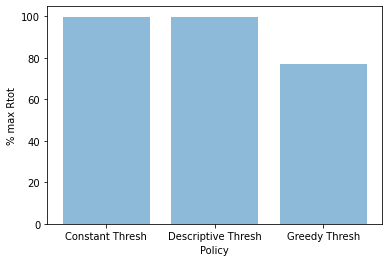

In [9]:
# Plot a histogram: each model's Rtot as a % of the oracle Rtot
frac = np.zeros(len(Rtot))
for i,r in enumerate(Rtot):
    frac[i] = (r[-1]/Rtot[-1][-1])*100
    
y_pos = np.arange(len(Rtot)-1)

plt.bar(y_pos, frac[0:-1], align='center', alpha=0.5)
plt.xticks(y_pos, names[1:-1])
plt.xlabel('Policy')
plt.ylabel('% max Rtot')

plt.show()